In [1]:
#@title Configuration
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark


Mounted at /content/drive


In [2]:
#@title Common Imports
from pyspark import SparkContext, SparkConf
import sys
import json
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate()
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import widgets
from IPython.display import display

from math import sqrt
from os.path import exists

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import Evaluator
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
from pyspark.sql.functions import unix_timestamp

In [3]:
#@title Gold Data Initialization { display-mode: "both" }
# load pollution data from CSV
pg = spark.read.option("header",True).option("inferSchema",True).csv("/content/drive/Shareddrives/ProjectSharedDrive/Gold/2021.csv")
p1g = pg.drop("Instrument Type").drop("Avg Daily Turnover (Lacs)").drop("Segment").withColumnRenamed("Total Value (Lacs)","Total_Val").withColumnRenamed("Traded Contract(Lots)","Traded_Contract").withColumnRenamed("Date","Gold_Date")
p1g.count()
pg20 = spark.read.option("header",True).option("inferSchema",True).csv("/content/drive/Shareddrives/ProjectSharedDrive/Gold/2020.csv")
p1g20 = pg20.drop("Instrument Type").drop("Avg Daily Turnover (Lacs)").drop("Segment").withColumnRenamed("Total Value (Lacs)","Total_Val").withColumnRenamed("Traded Contract(Lots)","Traded_Contract").withColumnRenamed("Date","Gold_Date")

pg19 = spark.read.option("header",True).option("inferSchema",True).csv("/content/drive/Shareddrives/ProjectSharedDrive/Gold/2019.csv")
p1g19 = pg19.drop("Instrument Type").drop("Avg Daily Turnover (Lacs)").drop("Segment").withColumnRenamed("Total Value (Lacs)","Total_Val").withColumnRenamed("Traded Contract(Lots)","Traded_Contract").withColumnRenamed("Date","Gold_Date")

pg18 = spark.read.option("header",True).option("inferSchema",True).csv("/content/drive/Shareddrives/ProjectSharedDrive/Gold/2018.csv")
p1g18 = pg18.drop("Instrument Type").drop("Avg Daily Turnover (Lacs)").drop("Segment").withColumnRenamed("Total Value (Lacs)","Total_Val").withColumnRenamed("Traded Contract(Lots)","Traded_Contract").withColumnRenamed("Date","Gold_Date")

gold = p1g.union(p1g20).union(p1g19).union(p1g18)
ts = unix_timestamp("Gold_Date", "dd-MMM-yy").cast("timestamp").cast("date")
p2g = gold.select("Gold_Date","Traded_Contract").withColumn("gold_date",ts)

File path, Folder ID, Constants and other related information

In [4]:
#@title File path, Folder ID, Constants
drivepath = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVData"
driveDAILYpath = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVCumulative"
cryptofile = "/content/drive/Shareddrives/ProjectSharedDrive/top25_cryptocoins_list.jsonl"


In [5]:
#@title Load Coin Details
fileRef = open(driveDAILYpath+"/USDTCoinName.txt" ,"r")
coinName = []
coinCode = []
for lines in fileRef:
  name = eval(lines[:-1])
  coinName.append(name[1])
  coinCode.append(name)

_crypt_raw = spark.read.json(cryptofile)
_crypt = _crypt_raw.withColumn("name", F.col("name")) \
          .withColumn("symbol", F.col("symbol")) \
          .withColumn("cmc_rank", F.col("cmc_rank")).orderBy("cmc_rank")
#_crypt.show()
top10=[]
j=0
for i in _crypt.collect():
   top10.append(i[1])
   j+=1
   if(j==10):
     break

## **Interactive Display for Gold Data Correlation**

Processing for Top 10 Coins

In [6]:
#@title Perform the Gold Data Correlation
corr=[]

for i in top10:
  coinChosen = [item for item in coinCode if item[1] == i]
  coinname = i
  coinfile = driveDAILYpath+"/"+coinChosen[0][0]+"DAILY.csv"
  coinn = spark.read.option("header",True).option("inferSchema",True).csv(coinfile)
  p2 = coinn.drop("_c0").drop("Open").drop("High").drop("Close").drop("Low")
  p3 = p2.select(col("Date").cast("date"),"Volume")
  joindf = p3.join(p2g,(p3.Date==p2g.gold_date)).drop("gold_date") #.withColumn("month",month("Date")).withColumn("year",year("Date"))
  corr.append(joindf.corr("Volume","Traded_Contract"))

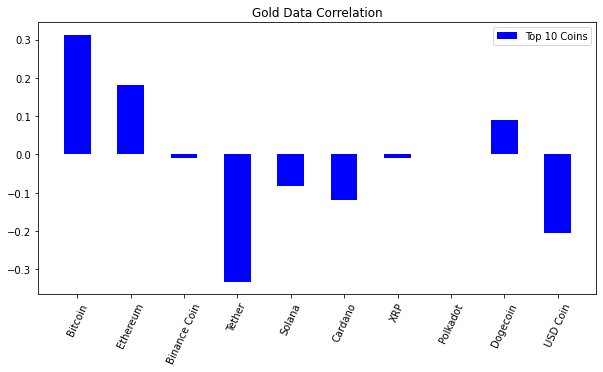

In [8]:
#@title Graph Plotting

plt.bar(top10, corr, color ='blue',width = 0.5, label="Top 10 Coins")
plt.xticks(rotation=65)
plt.title("Gold Data Correlation")
plt.rcParams["figure.figsize"] = (10,5)
plt.legend(loc="upper right")
plt.show()